In [17]:
import numpy as np
from pprint import pprint
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [54]:
def my_accuracy(y_true, y_pred):
    y_pred = np.where(y_pred > 0.5, 1, 0)
    return accuracy_score(y_true, y_pred)

def plot_gs_results(gs_model, params, check_params, model_name = ''):
    plt.figure(figsize=(12,6))
    ## plt.title(model_name + " dependency from "+ str(check_params))
    plt.plot(params[check_params], gs_model.cv_results_["mean_train_score"],"o-",label="train")
    plt.plot(params[check_params], gs_model.cv_results_["mean_test_score"],"o-",label="test")
    plt.xlabel(check_params)
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

def gs_regressor_params(parameters ={}, check_parameter={}, metric="accuracy", reg=None, n_splits=1, test_size=0.20):
    metric = make_scorer(my_accuracy)
    cv = TimeSeriesSplit(n_splits=n_splits)
    gs_reg = GridSearchCV(reg, parameters, cv=cv, scoring=metric, return_train_score=True, verbose=False)
    gs_reg.fit(X_train,y_train)
    plot_gs_results(gs_model=gs_reg, params=parameters, check_params = check_parameter, model_name=str(reg))

### stats_amount: 800
### missings: true
### test_period_index: <font color='red'>5</font>
### algorithm: XGB
### n_splits: 10
### lag_window: 30
### X_train_start_date: 2015-06-01

In [24]:
data = pd.read_pickle('final_data.pkl')
print(data.shape)
data.head(1)

(36814, 828)


,,,Surface,hour,round,p1_win,p1_age,p2_age,k1,k2,p1_height,p2_height,...,p2_filter_lag_1_bp_saved_cnt__mean_28_y,p2_filter_lag_1_bp_saved_cnt__median_28_y,p1_lag_1_match_duration_mnt_mean_28,p1_lag_1_match_duration_mnt_median_28,p1_filter_lag_1_match_duration_mnt_mean_28,p1_filter_lag_1_match_duration_mnt_median_28,p2_lag_1_match_duration_mnt_mean_28,p2_lag_1_match_duration_mnt_median_28,p2_filter_lag_1_match_duration_mnt_mean_28,p2_filter_lag_1_match_duration_mnt_median_28
date,p1,p2,,,,,,,,,,,,,,,,,,,,,
2015-06-01,Gasquet R.,Djokovic N.,0.0,18,1.0,0,28.046575,28.972603,19.0,1.0,1.88,1.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
y = data['p1_win'].astype(int)
X = data.drop(['p1_win'], axis=1)
date_idx = X.index.get_level_values('date')

In [26]:
test_periods = [
    ('2019-01-01', '2019-04-01'),
    ('2019-04-01', '2019-07-01'),
    ('2019-07-01', '2019-10-01'),
    ('2019-10-01', '2020-04-01'),
    ('2020-08-01', '2020-11-01'),
]

for p in test_periods:
    n_test = data[(date_idx >= p[0]) & (date_idx < p[1])].shape[0]
    print('test period: {}, match count: {:,}'.format(p, n_test))

test period: ('2019-01-01', '2019-04-01'), match count: 2,178
test period: ('2019-04-01', '2019-07-01'), match count: 2,216
test period: ('2019-07-01', '2019-10-01'), match count: 2,170
test period: ('2019-10-01', '2020-04-01'), match count: 2,608
test period: ('2020-08-01', '2020-11-01'), match count: 1,768


In [23]:
## TO DO: Протестить все тестовые периоды
test_from, test_to = test_periods[0]
d = date_idx
X_test = X[(date_idx >= test_from) & (date_idx < test_to)]
y_test = y[(date_idx >= test_from) & (date_idx < test_to)]
X_train = X[(date_idx < test_from)]
y_train = y[(date_idx < test_from)]
## X_train = X[(date_idx < test_from) & (date_idx  >= '2016-01-01')]
## y_train = y[(date_idx < test_from) & (date_idx >= '2016-01-01')]

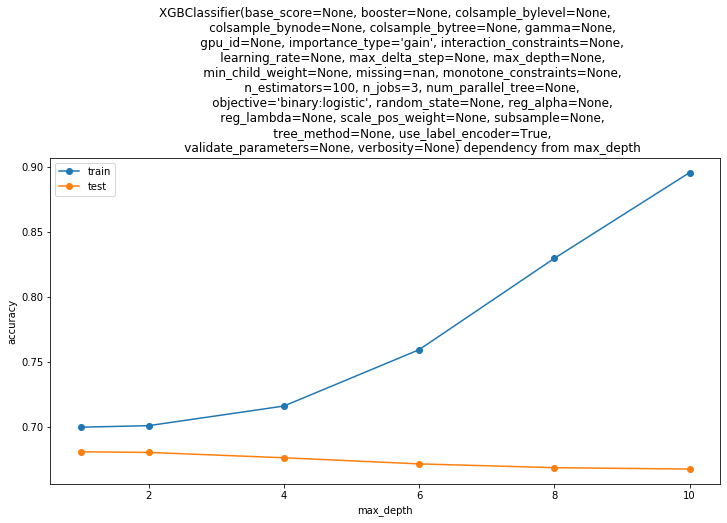

In [29]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [1, 2, 4, 6, 8, 10],
    'subsample': [1.0],
    'colsample_bytree': [0.8],
    'n_estimators': [150],
    'eval_metric' :["logloss"]
    
}
gs_regressor_params(parameters=grid_params, check_parameter='max_depth', reg= xgb.XGBClassifier(n_jobs=3), n_splits=10)

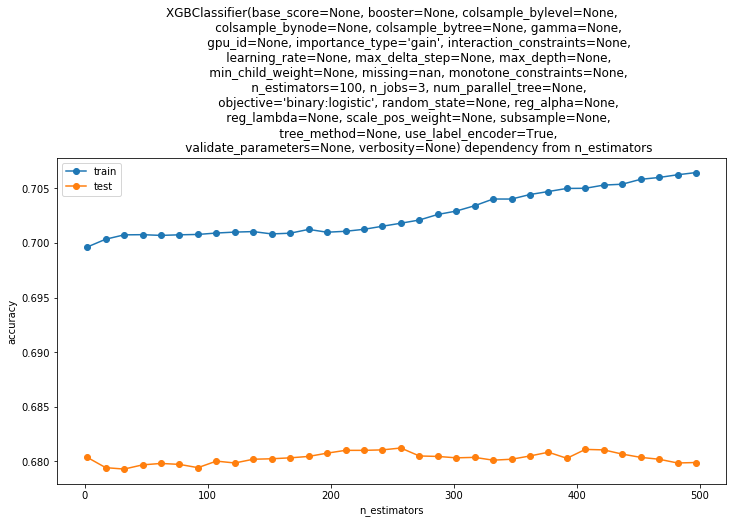

In [30]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [2],
    'subsample': [1.0],
    'colsample_bytree': [0.8],
    'n_estimators': range(2, 500, 15),
    'eval_metric' :["logloss"]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='n_estimators',reg=xgb.XGBClassifier(n_jobs=3), n_splits=10)

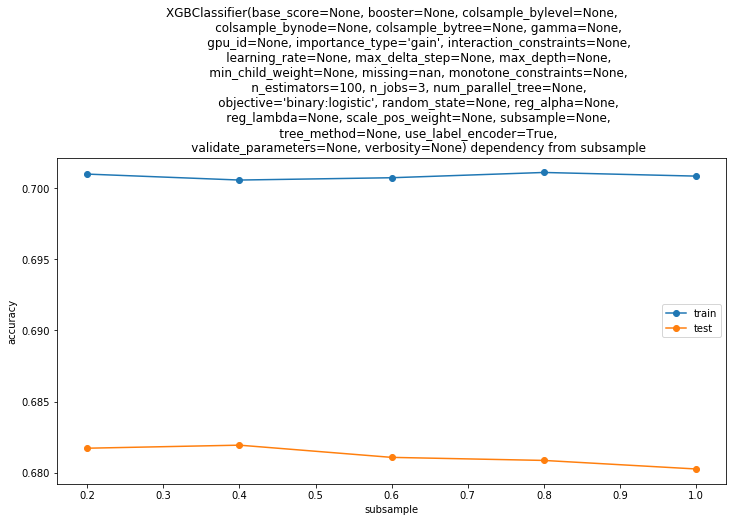

In [31]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [2],
    'subsample': [0.2, 0.4, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.8],
    'n_estimators': [150],
    'eval_metric' :["logloss"]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='subsample',reg=xgb.XGBClassifier(n_jobs=3), n_splits=10)

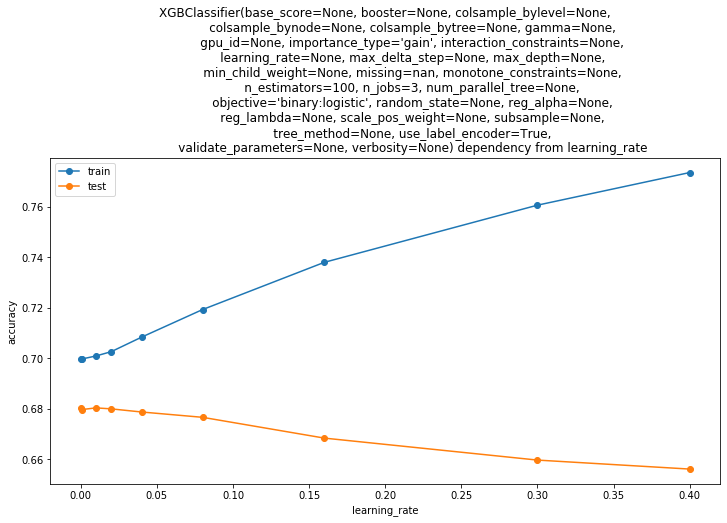

In [32]:
grid_params = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.02, 0.04, 0.08, 0.16, 0.3, 0.4], 
    'max_depth': [2],
    'subsample': [1.0],
    'colsample_bytree': [0.8],
    'n_estimators': [150],
    'eval_metric' :["logloss"]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='learning_rate',reg=xgb.XGBClassifier(n_jobs=3), n_splits=10)

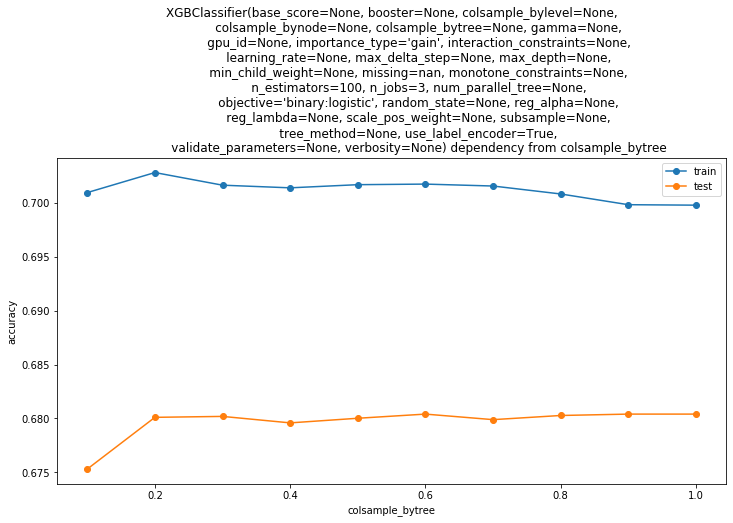

In [33]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [2],
    'subsample': [1.0],
    'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [150],
    'eval_metric' :["logloss"]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='colsample_bytree',reg=xgb.XGBClassifier(n_jobs=3), n_splits=10)

### stats_amount: 800
### missings: true
### test_period_index: <font color='red'>1</font>
### algorithm: XGB
### n_splits: 10
### lag_window: 30
### X_train_start_date: 2015-06-01

In [34]:
test_from, test_to = test_periods[1] ## period_ind = 1
d = date_idx
X_test = X[(date_idx >= test_from) & (date_idx < test_to)]
y_test = y[(date_idx >= test_from) & (date_idx < test_to)]
X_train = X[(date_idx < test_from)]
y_train = y[(date_idx < test_from)]
## X_train = X[(date_idx < test_from) & (date_idx  >= '2016-01-01')]
## y_train = y[(date_idx < test_from) & (date_idx >= '2016-01-01')]

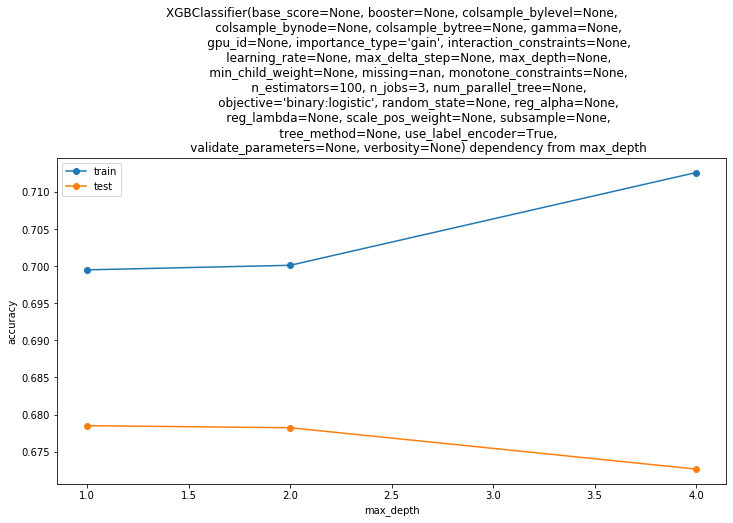

In [35]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [1, 2, 4],
    'subsample': [1.0],
    'colsample_bytree': [0.8],
    'n_estimators': [150],
    'eval_metric' :["logloss"]
    
}
gs_regressor_params(parameters=grid_params, check_parameter='max_depth',
                    reg= xgb.XGBClassifier(n_jobs=3), n_splits=10)

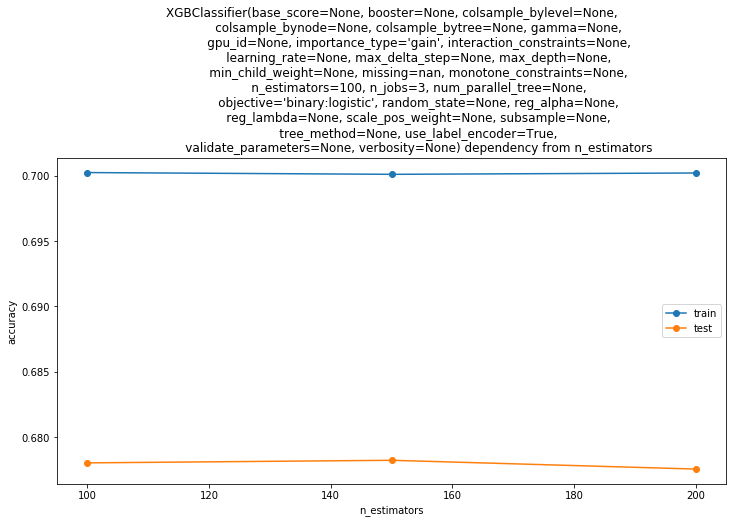

In [36]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [2],
    'subsample': [1.0],
    'colsample_bytree': [0.8],
    'n_estimators': range(100, 250, 50),
    'eval_metric' :["logloss"]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='n_estimators',reg=xgb.XGBClassifier(n_jobs=3), n_splits=10)

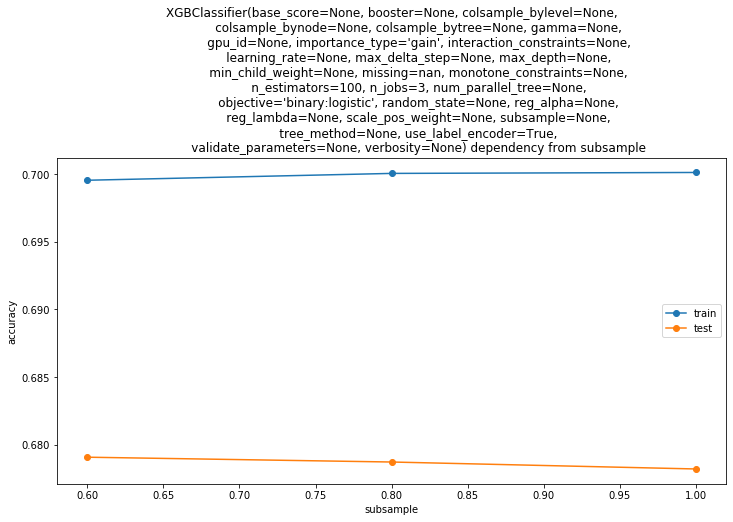

In [37]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.8],
    'n_estimators': [150],
    'eval_metric' :["logloss"]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='subsample',reg=xgb.XGBClassifier(n_jobs=3), n_splits=10)

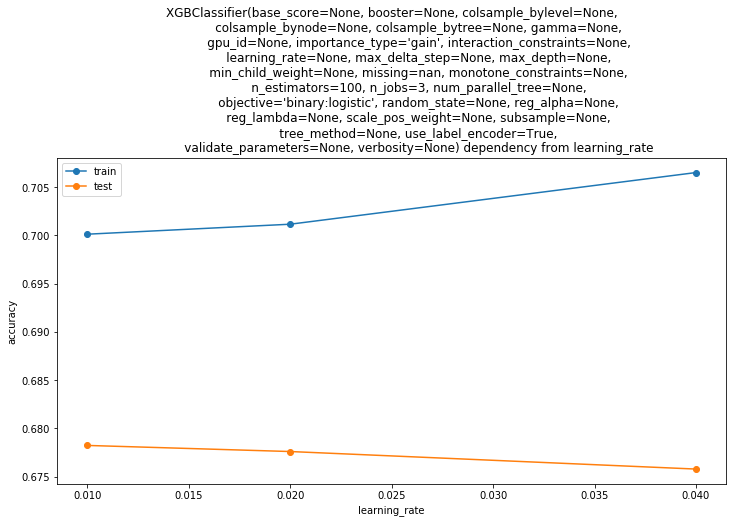

In [38]:
grid_params = {
    'learning_rate': [0.01, 0.02, 0.04], 
    'max_depth': [2],
    'subsample': [1.0],
    'colsample_bytree': [0.8],
    'n_estimators': [150],
    'eval_metric' :["logloss"]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='learning_rate',reg=xgb.XGBClassifier(n_jobs=3), n_splits=10)

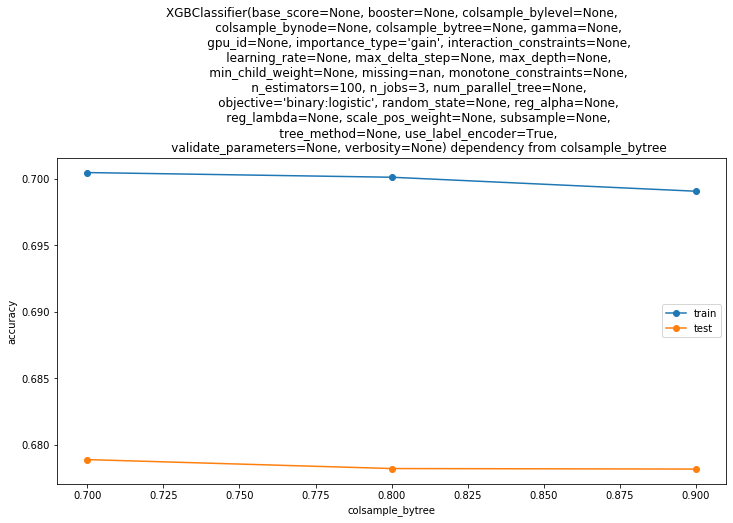

In [39]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [2],
    'subsample': [1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [150],
    'eval_metric' :["logloss"]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='colsample_bytree',reg=xgb.XGBClassifier(n_jobs=3), n_splits=10)

### stats_amount: 800
### missings: true
### test_period_index: 0
### algorithm: XGB
### n_splits: <font color='red'>5</font>
### lag_window: 30
### X_train_start_date: 2015-06-01

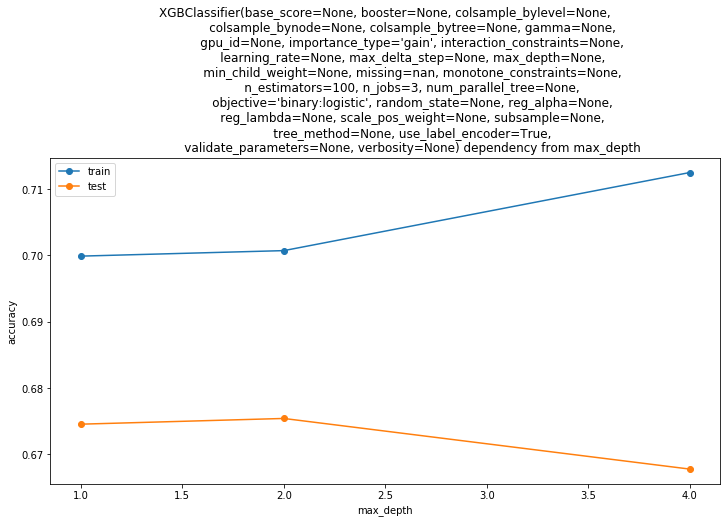

In [40]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [1, 2, 4],
    'subsample': [1.0],
    'colsample_bytree': [0.8],
    'n_estimators': [150],
    'eval_metric' :["logloss"]
    
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='max_depth', reg= xgb.XGBClassifier(n_jobs=3), n_splits=5)

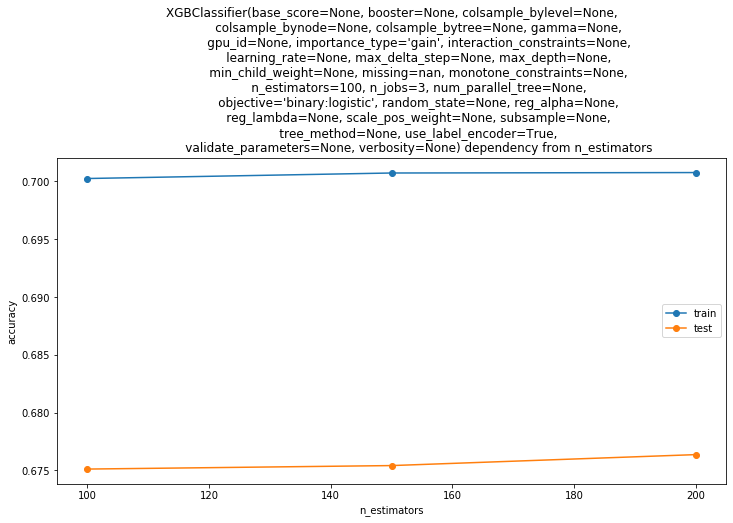

In [41]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [2],
    'subsample': [1.0],
    'colsample_bytree': [0.8],
    'n_estimators': range(100, 250, 50),
    'eval_metric' :["logloss"]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='n_estimators',reg=xgb.XGBClassifier(n_jobs=3), n_splits=5)

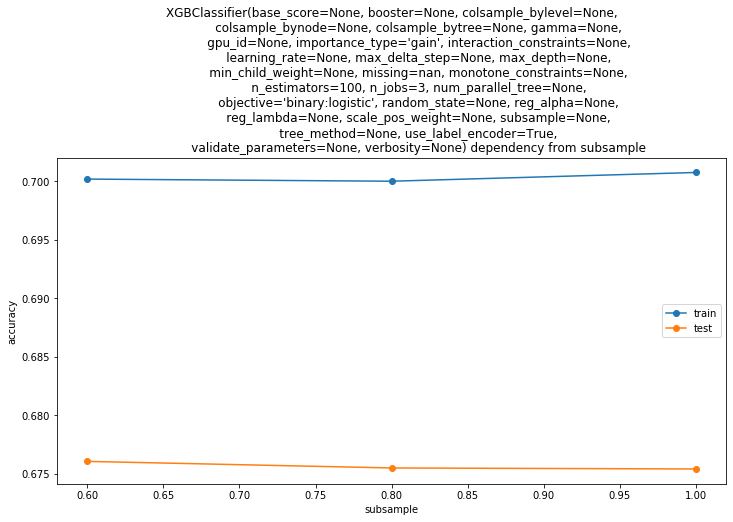

In [42]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.8],
    'n_estimators': [150],
    'eval_metric' :["logloss"]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='subsample',reg=xgb.XGBClassifier(n_jobs=3), n_splits=5)

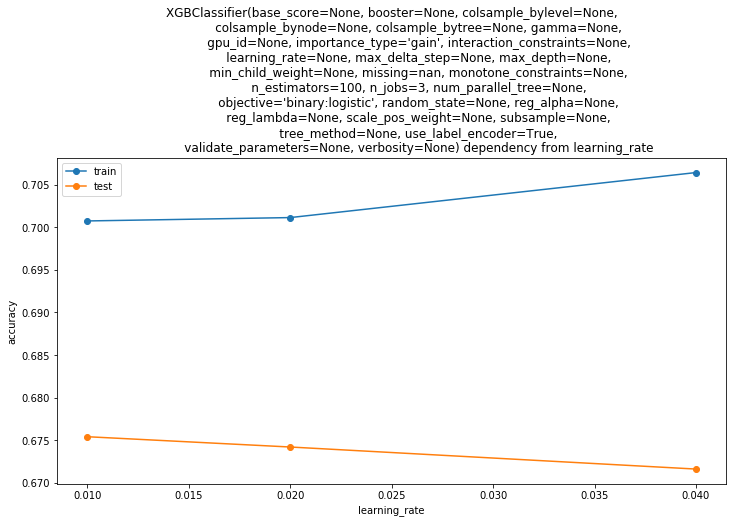

In [43]:
grid_params = {
    'learning_rate': [0.01, 0.02, 0.04], 
    'max_depth': [2],
    'subsample': [1.0],
    'colsample_bytree': [0.8],
    'n_estimators': [150],
    'eval_metric' :["logloss"]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='learning_rate',reg=xgb.XGBClassifier(n_jobs=3), n_splits=5)

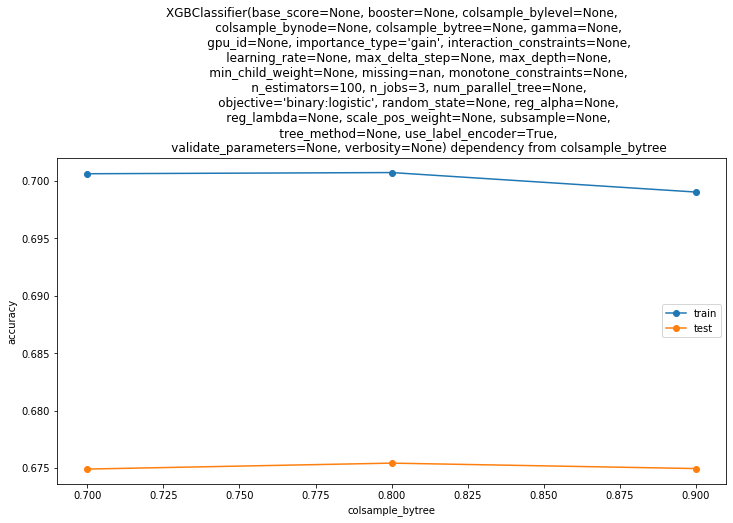

In [44]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [2],
    'subsample': [1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [150],
    'eval_metric' :["logloss"]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='colsample_bytree',reg=xgb.XGBClassifier(n_jobs=3), n_splits=5)

### stats_amount: 800
### missings: true
### test_period_index: 0
### algorithm: XGB
### n_splits: <font color='red'>15</font>
### lag_window: 30
### X_train_start_date: 2015-06-01

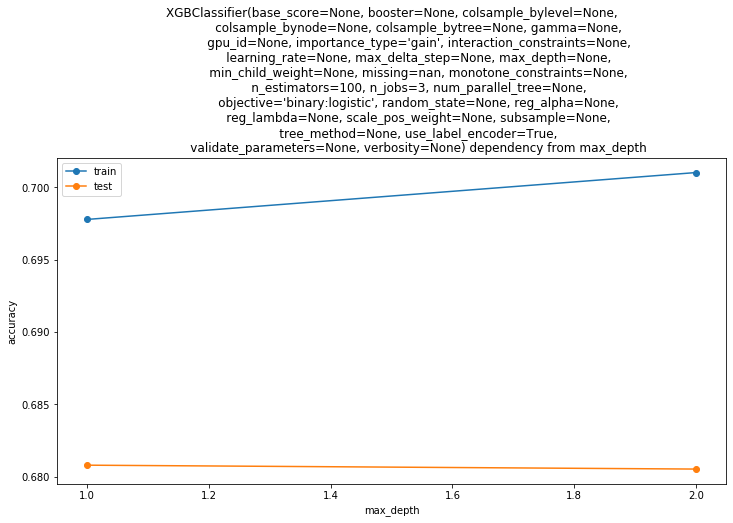

In [47]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [1, 2],
    'subsample': [0.4],
    'colsample_bytree': [0.8],
    'n_estimators': [260],
    'eval_metric' :["logloss"]
    
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='max_depth', reg= xgb.XGBClassifier(n_jobs=3), n_splits=15)

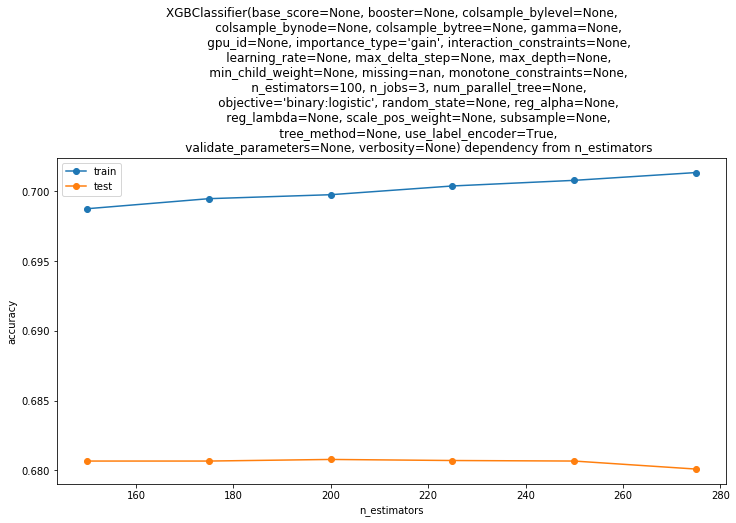

In [48]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [2],
    'subsample': [0.4],
    'colsample_bytree': [0.8],
    'n_estimators': range(150, 300, 25),
    'eval_metric' :["logloss"]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='n_estimators',reg=xgb.XGBClassifier(n_jobs=3), n_splits=15)

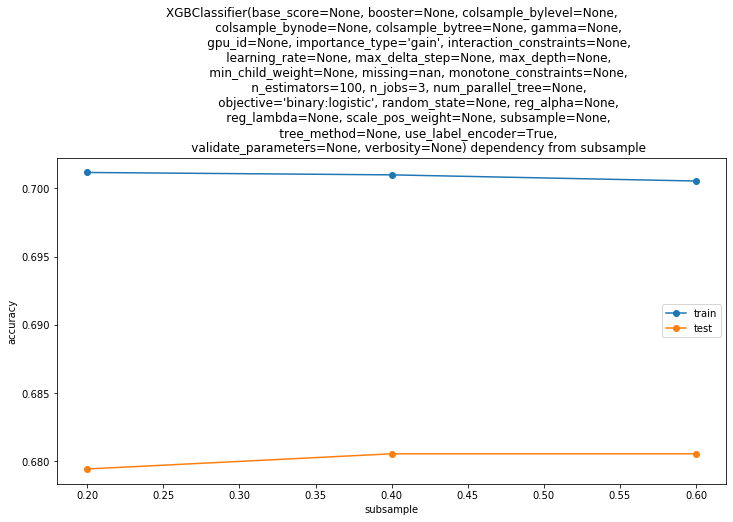

In [49]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [2],
    'subsample': [0.2, 0.4, 0.6],
    'colsample_bytree': [0.8],
    'n_estimators': [260],
    'eval_metric' :["logloss"]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='subsample',reg=xgb.XGBClassifier(n_jobs=3), n_splits=15)

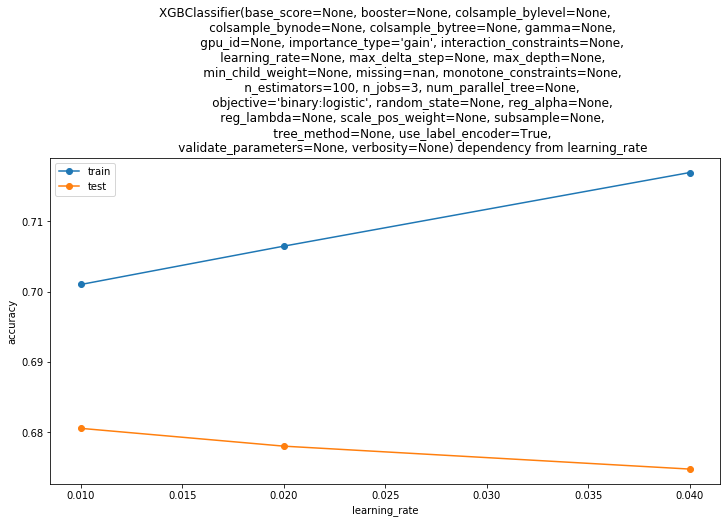

In [50]:
grid_params = {
    'learning_rate': [0.01, 0.02, 0.04], 
    'max_depth': [2],
    'subsample': [0.4],
    'colsample_bytree': [0.8],
    'n_estimators': [260],
    'eval_metric' :["logloss"]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='learning_rate',reg=xgb.XGBClassifier(n_jobs=3), n_splits=15)

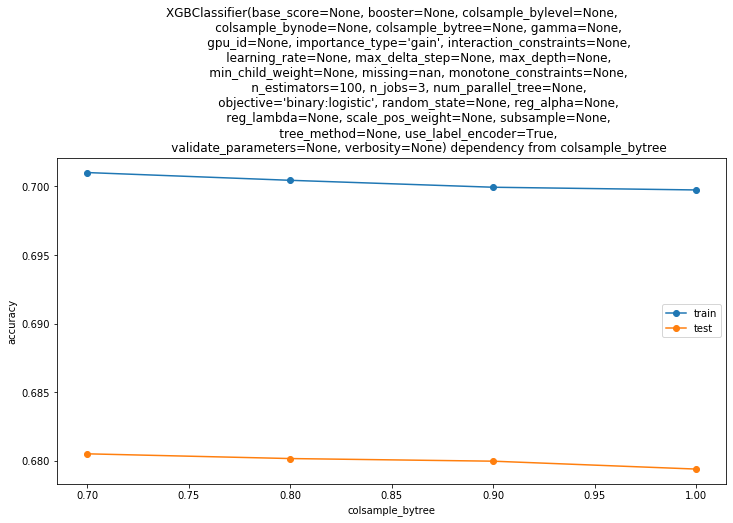

In [51]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [2],
    'subsample': [0.8],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'n_estimators': [260],
    'eval_metric' :["logloss"]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='colsample_bytree',reg=xgb.XGBClassifier(n_jobs=3), n_splits=15)

### stats_amount: 800
### missings: true
### test_period_index: 0
### algorithm: XGB
### n_splits 15
### lag_window: 30
### X_train_start_date: <font color='red'>2017-01-01</font>

In [52]:
test_from, test_to = test_periods[0]
d = date_idx
X_test = X[(date_idx >= test_from) & (date_idx < test_to)]
y_test = y[(date_idx >= test_from) & (date_idx < test_to)]
## X_train = X[(date_idx < test_from)]
## y_train = y[(date_idx < test_from)]
X_train = X[(date_idx < test_from) & (date_idx  >= '2017-01-01')]
y_train = y[(date_idx < test_from) & (date_idx >= '2017-01-01')]

In [ ]:
grid_params = {
    'learning_rate': [0.001, 0.01, 0.015, 0.02], 
    'max_depth': [1, 2, 3, 4],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.8],
    'n_estimators': range(150, 300, 50),
    'eval_metric' :["logloss"]
    
}
metric = make_scorer(my_accuracy)
cv = TimeSeriesSplit(n_splits=10)
gs_reg = GridSearchCV(xgb.XGBClassifier(n_jobs=3), grid_params, cv=cv, scoring=metric, return_train_score=True, verbose=False)
gs_reg.fit(X_train,y_train)